2025-01-26 17:57:27.026646: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-01-26 17:57:27.026662: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-01-26 17:57:27.026666: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-01-26 17:57:27.026857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-26 17:57:27.026866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-01-26 17:57:27.962286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
[*********************100%***********************]  1 of 1 completed



Mean Absolute Percentage Error (MAPE) for Last Week: 3.80%
Root Mean Squared Error (RMSE) for Last Week: 11.64


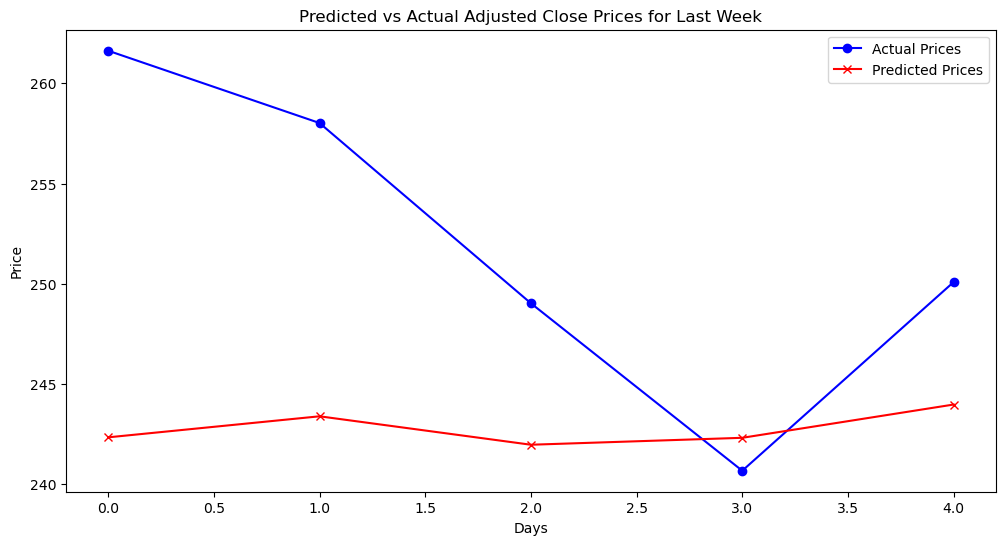

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[*********************100%***********************]  1 of 1 completed


Mean Absolute Percentage Error (MAPE) for Last Month: 16.22%
Root Mean Squared Error (RMSE) for Last Month: 44.70


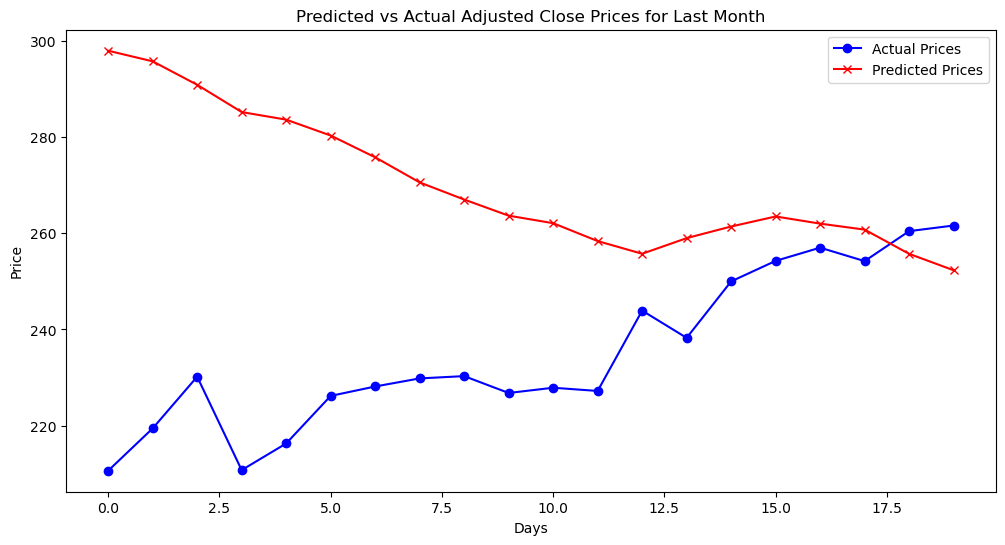

In [1]:
import sys
import os

# Get the absolute path to the `src` directory
src_path = os.path.abspath(os.path.join('..', 'src'))

# Add the `src` directory to the Python path
if src_path not in sys.path:
    sys.path.append(src_path)

import numpy as np
import pandas as pd
from data_processing import fetch_data_prior_to_last_month, fetch_data_up_to_last_week, fetch_last_week_data, fetch_last_month_data, preprocess_data, create_lstm_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from lstm_model import Attention

# Load the model
model = load_model("../models/lstm_tsla_model_rework_v5.h5", custom_objects={'Attention': Attention})

# --- Predictions for Last Week ---

# Fetch and preprocess historical data up to last week
historical_data_up_to_last_week = fetch_data_up_to_last_week()
preprocessed_data_last_week, scaler = preprocess_data(historical_data_up_to_last_week)

# Prepare input data with the lookback period for predictions
lookback = 20
X_input, _ = create_lstm_input(preprocessed_data_last_week, target_column='Adj Close', lookback=lookback)

# Make predictions for the last week (using the last 5 days in the input)
predicted_weekly_prices = model.predict(X_input[-5:])

# Inverse transform the predictions
predicted_weekly_prices_padded = np.zeros((predicted_weekly_prices.shape[0], scaler.min_.shape[0]))
predicted_weekly_prices_padded[:, 0] = predicted_weekly_prices.flatten()
predicted_weekly_prices_rescaled = scaler.inverse_transform(predicted_weekly_prices_padded)[:, 0]

# Fetch actual prices for last week
actual_weekly_prices = fetch_last_week_data()['Adj Close'].values

# Calculate error metrics for the last week
mape_week = mean_absolute_percentage_error(actual_weekly_prices, predicted_weekly_prices_rescaled)
rmse_week = np.sqrt(mean_squared_error(actual_weekly_prices, predicted_weekly_prices_rescaled))

# Display weekly results
print(f"\nMean Absolute Percentage Error (MAPE) for Last Week: {mape_week * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE) for Last Week: {rmse_week:.2f}")

# Plot predictions vs. actual prices for the last week
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_weekly_prices)), actual_weekly_prices, label='Actual Prices', color='blue', marker='o')
plt.plot(range(len(predicted_weekly_prices_rescaled)), predicted_weekly_prices_rescaled, label='Predicted Prices', color='red', marker='x')
plt.title('Predicted vs Actual Adjusted Close Prices for Last Week')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# --- Predictions for Last Month ---

# Fetch and preprocess historical data up to the last month
historical_data_up_to_last_month = fetch_data_prior_to_last_month()
preprocessed_data_last_month, scaler = preprocess_data(historical_data_up_to_last_month)

# Prepare input data for the last month (assuming lookback period remains 20)
X_last_month_input, _ = create_lstm_input(preprocessed_data_last_month, target_column='Adj Close', lookback=lookback)

# Make predictions for the last month
last_month_length = len(fetch_last_month_data())  # Get the number of days in the last month
predicted_monthly_prices = model.predict(X_last_month_input[-last_month_length:])

# Inverse transform the predictions to get actual prices
predicted_monthly_prices_padded = np.zeros((predicted_monthly_prices.shape[0], scaler.min_.shape[0]))
predicted_monthly_prices_padded[:, 0] = predicted_monthly_prices.flatten()
predicted_monthly_prices_rescaled = scaler.inverse_transform(predicted_monthly_prices_padded)[:, 0]

# Fetch actual prices for the last month
actual_monthly_prices = fetch_last_month_data()['Adj Close'].values

# Calculate error metrics for the last month
mape_month = mean_absolute_percentage_error(actual_monthly_prices, predicted_monthly_prices_rescaled)
rmse_month = np.sqrt(mean_squared_error(actual_monthly_prices, predicted_monthly_prices_rescaled))

# Display monthly results
print(f"\nMean Absolute Percentage Error (MAPE) for Last Month: {mape_month * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE) for Last Month: {rmse_month:.2f}")

# Plot predictions vs. actual prices for the last month
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_monthly_prices)), actual_monthly_prices, label='Actual Prices', color='blue', marker='o')
plt.plot(range(len(predicted_monthly_prices_rescaled)), predicted_monthly_prices_rescaled, label='Predicted Prices', color='red', marker='x')
plt.title('Predicted vs Actual Adjusted Close Prices for Last Month')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
